In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use('seaborn')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [5]:
df = pd.read_csv('Churn_Modelling.csv')
df.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


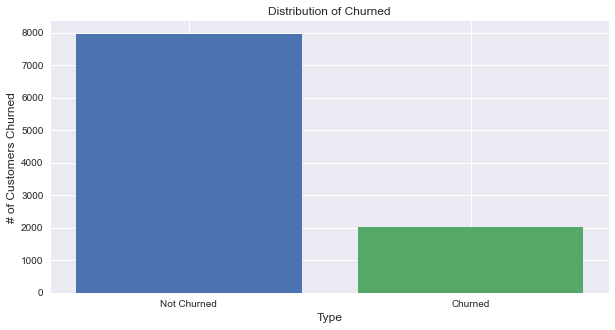

In [23]:
plt.figure(figsize=(10, 5))
plt.bar('Not Churned', len(df[df['Exited'] == 0]))
plt.bar('Churned', len(df[df['Exited'] == 1]))
plt.title('Distribution of Churned', size=12)
plt.xlabel('Type', size=12)
plt.ylabel('# of Customers Churned', size=12);

# Data Cleaning

In [7]:
df1 = pd.get_dummies(data=df, columns=['Geography', 'Gender'])
df1.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
col_to_scale=['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']

df1[col_to_scale] = scaler.fit_transform(df1[col_to_scale])

In [12]:
df1.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0,1,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,0,1,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0,1,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0,1,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,0,1,1,0


# Modelling

In [27]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Data As Is 

In [13]:
X = df1.drop(columns=['Exited'])
y = df1['Exited']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify=y)

In [34]:
def ANN(X_train, y_train, X_test, y_test, loss='binary_crossentropy'):
    model = keras.Sequential([
        keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(optimizer='adam', loss=loss, metrics=METRICS)

    
    model.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

    print(model.evaluate(X_test, y_test))

    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    matrix = confusion_matrix(y_preds, y_test, normalize='all')
    plt.figure(figsize=(10, 6))
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, ax = ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted Labels', size=15)
    ax.set_ylabel('True Labels', size=15)
    ax.set_title('Confusion Matrix', size=15)
    ax.xaxis.set_ticklabels([0,1], size=15)
    ax.yaxis.set_ticklabels([0,1], size=15);
    plt.show()
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

Epoch 1/100
201/201 [==============================] - 1s 3ms/step - loss: 0.4839 - accuracy: 0.7964 - precision: 0.4778 - recall: 0.0351 - val_loss: 0.4667 - val_accuracy: 0.7985 - val_precision: 0.6667 - val_recall: 0.0851
Epoch 2/100
201/201 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.8066 - precision: 0.6859 - recall: 0.0874 - val_loss: 0.4538 - val_accuracy: 0.8045 - val_precision: 0.6562 - val_recall: 0.1489
Epoch 3/100
201/201 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.8123 - precision: 0.6667 - recall: 0.1503 - val_loss: 0.4499 - val_accuracy: 0.8030 - val_precision: 0.7647 - val_recall: 0.0922
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 0.4218 - accuracy: 0.8179 - precision: 0.6864 - recall: 0.1895 - val_loss: 0.4348 - val_accuracy: 0.8164 - val_precision: 0.7368 - val_recall: 0.1986
Epoch 5/100
201/201 [==============================] - 0s 2ms/step - loss: 0.4115 - accuracy: 0.8224

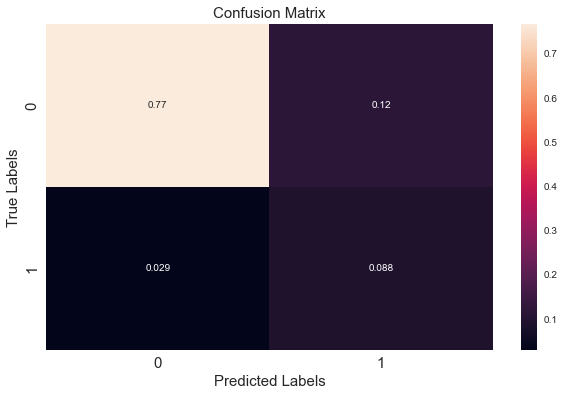

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      2628
           1       0.75      0.43      0.55       672

    accuracy                           0.86      3300
   macro avg       0.81      0.70      0.73      3300
weighted avg       0.85      0.86      0.84      3300



In [35]:
y_preds = ANN(X_train, y_train, X_test, y_test)

## Undersampling

In [36]:
count_class_0, count_class_1 = y.value_counts()

# Divide by class
df_class_0 = df1[y == 0]
df_class_1 = df1[y == 1]

In [38]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Exited.value_counts())

Random under-sampling:
0    2037
1    2037
Name: Exited, dtype: int64


In [39]:
X = df_test_under.drop(columns=['Exited'])
y = df_test_under['Exited']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify=y)

Epoch 1/100
82/82 [==============================] - 1s 6ms/step - loss: 0.6733 - accuracy: 0.5774 - precision: 0.5567 - recall: 0.7727 - val_loss: 0.6494 - val_accuracy: 0.6374 - val_precision: 0.6065 - val_recall: 0.7121
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.6397 - precision: 0.6376 - recall: 0.6526 - val_loss: 0.6131 - val_accuracy: 0.7033 - val_precision: 0.7429 - val_recall: 0.5909
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 0.6115 - accuracy: 0.6665 - precision: 0.6794 - recall: 0.6347 - val_loss: 0.5925 - val_accuracy: 0.7143 - val_precision: 0.7077 - val_recall: 0.6970
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.6816 - precision: 0.6860 - recall: 0.6737 - val_loss: 0.5776 - val_accuracy: 0.7326 - val_precision: 0.7521 - val_recall: 0.6667
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 0.5843 - accuracy: 0.6938 - precisi

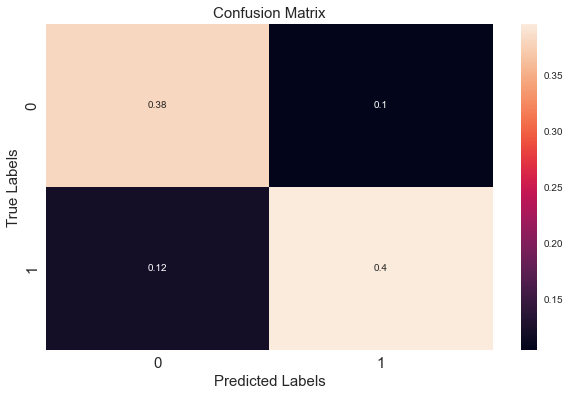

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.76      0.77       672
           1       0.77      0.79      0.78       673

    accuracy                           0.78      1345
   macro avg       0.78      0.78      0.78      1345
weighted avg       0.78      0.78      0.78      1345



In [41]:
y_preds = ANN(X_train, y_train, X_test, y_test)

## Oversampling

In [42]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Exited.value_counts())

Random over-sampling:
0    7963
1    7963
Name: Exited, dtype: int64


In [44]:
X = df_test_over.drop(columns=['Exited'])
y = df_test_over['Exited']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify=y)

Epoch 1/100
321/321 [==============================] - 2s 3ms/step - loss: 0.6295 - accuracy: 0.6473 - precision: 0.6547 - recall: 0.6218 - val_loss: 0.5983 - val_accuracy: 0.6945 - val_precision: 0.7031 - val_recall: 0.6822
Epoch 2/100
321/321 [==============================] - 1s 2ms/step - loss: 0.5784 - accuracy: 0.6986 - precision: 0.6973 - recall: 0.7011 - val_loss: 0.5760 - val_accuracy: 0.7160 - val_precision: 0.7505 - val_recall: 0.6543
Epoch 3/100
321/321 [==============================] - 1s 2ms/step - loss: 0.5421 - accuracy: 0.7305 - precision: 0.7331 - recall: 0.7242 - val_loss: 0.5490 - val_accuracy: 0.7338 - val_precision: 0.7003 - val_recall: 0.8253
Epoch 4/100
321/321 [==============================] - 1s 2ms/step - loss: 0.5063 - accuracy: 0.7549 - precision: 0.7549 - recall: 0.7542 - val_loss: 0.5216 - val_accuracy: 0.7545 - val_precision: 0.7308 - val_recall: 0.8123
Epoch 5/100
321/321 [==============================] - 1s 2ms/step - loss: 0.4830 - accuracy: 0.7640

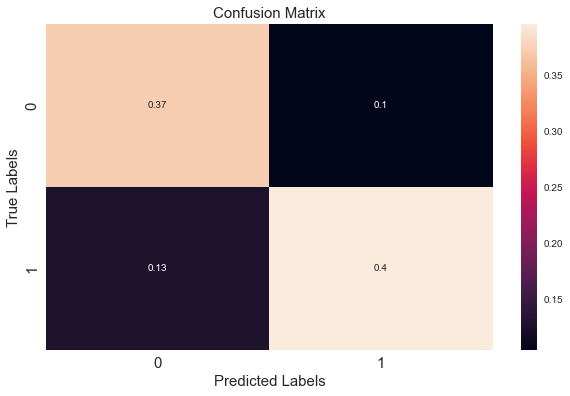

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      2628
           1       0.76      0.79      0.77      2628

    accuracy                           0.77      5256
   macro avg       0.77      0.77      0.77      5256
weighted avg       0.77      0.77      0.77      5256



In [46]:
y_preds = ANN(X_train, y_train, X_test, y_test)

## SMOTE

In [47]:
!pip install imbalanced-learn

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
X = df1.drop('Exited', axis='columns')
y = df1['Exited']

In [50]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

0    7963
1    7963
Name: Exited, dtype: int64

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=10, stratify=y_sm)

Epoch 1/100
321/321 [==============================] - 2s 3ms/step - loss: 0.6249 - accuracy: 0.6552 - precision: 0.6631 - recall: 0.6298 - val_loss: 0.5929 - val_accuracy: 0.6926 - val_precision: 0.6959 - val_recall: 0.6933
Epoch 2/100
321/321 [==============================] - 1s 2ms/step - loss: 0.5759 - accuracy: 0.7022 - precision: 0.6975 - recall: 0.7132 - val_loss: 0.5717 - val_accuracy: 0.7132 - val_precision: 0.7239 - val_recall: 0.6970
Epoch 3/100
321/321 [==============================] - 1s 2ms/step - loss: 0.5495 - accuracy: 0.7270 - precision: 0.7247 - recall: 0.7311 - val_loss: 0.5489 - val_accuracy: 0.7320 - val_precision: 0.7218 - val_recall: 0.7621
Epoch 4/100
321/321 [==============================] - 1s 2ms/step - loss: 0.5208 - accuracy: 0.7431 - precision: 0.7469 - recall: 0.7346 - val_loss: 0.5276 - val_accuracy: 0.7591 - val_precision: 0.7322 - val_recall: 0.8234
Epoch 5/100
321/321 [==============================] - 1s 2ms/step - loss: 0.4991 - accuracy: 0.7547

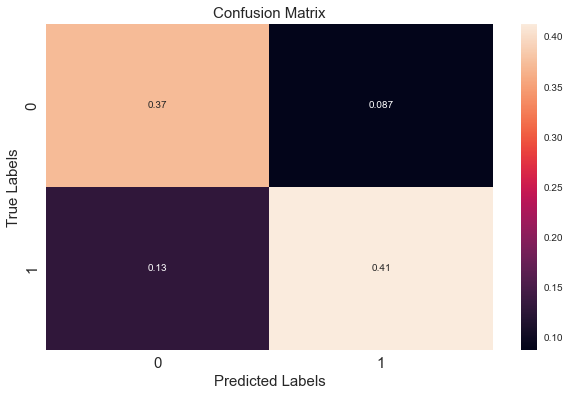

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      2628
           1       0.76      0.83      0.79      2628

    accuracy                           0.78      5256
   macro avg       0.79      0.78      0.78      5256
weighted avg       0.79      0.78      0.78      5256



In [53]:
y_preds = ANN(X_train, y_train, X_test, y_test)